# Final Project Submission

Please fill out:
* Student name: Nopasorn Kowathanakul
* Student pace: Self-paced
* Scheduled project review date: Jan 11, 2022
* Instructor name: Abhineet Kulkarni
* Blog post URL: https://knotmirai.com/en/data-science-en/bitcoin-price-forecasting/

# Bitcoin Price Forecasting

Bitcoin is the longest-running and most well-known cryptocurrency, first released as open-source in 2009 by the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record-keeping authority or central intermediary. Transaction blocks contain an SHA-256 cryptographic hash of previous transaction blocks and are thus "chained" together, serving as an immutable record of all transactions that have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments soon followed the public adoption of bitcoin and continue to grow. **Can we predict the price of bitcoin?**

This Kernel is divided into two parts:-

* Data Exploration
* Time Series Forecasting (Univariate/Multivariate)

**Univariate time series:** Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature

**Multivariate time series:** Multiple variables are varying over time. For example, a tri-axial accelerometer. There are three accelerations, one for each axis (x,y,z) and they vary simultaneously over time.

And further for the **Time Series Forecasting:**-

1. Time Series Forecasting with **Prophet**
2. Time Series Forecasting with **LSTM**

In [1]:
# Import libraries
import numpy as np
from numpy import concatenate

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import pyplot
from plotly import tools
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.style.use('seaborn-poster')

from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from itertools import product
from datetime import datetime

import math
from math import sqrt

from fbprophet import Prophet

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In this project, we will use two sets of data:

1. Historical Bitcoin Price
2. Crypto Fear and Greed Index

### 1. Historical Bitcoin Price

Bitcoin price history can be obtained from many sources such as Yahoo Finance, Coinbase, and so on.

This dataset contains:

* Start Time Period
* End Time Period
* Open Time
* Close Time
* Open Price
* Close Price
* High Price
* Low Price
* Trade Volume
* Trade Count

In [2]:
# Load data and preview data info
df1 = pd.read_csv('initial_btc1_price.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2922 entries, 0 to 2921
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2922 non-null   int64  
 1   time_period_start  2922 non-null   object 
 2   time_period_end    2922 non-null   object 
 3   time_open          2922 non-null   object 
 4   time_close         2922 non-null   object 
 5   price_open         2922 non-null   float64
 6   price_high         2922 non-null   float64
 7   price_low          2922 non-null   float64
 8   price_close        2922 non-null   float64
 9   volume_traded      2922 non-null   float64
 10  trades_count       2922 non-null   int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 251.2+ KB


In [3]:
# Preview data
df1.head()

Unnamed: 0             time_period_start               time_period_end  \
0           0  2014-01-01T00:00:00.0000000Z  2014-01-02T00:00:00.0000000Z   
1           1  2014-01-02T00:00:00.0000000Z  2014-01-03T00:00:00.0000000Z   
2           2  2014-01-03T00:00:00.0000000Z  2014-01-04T00:00:00.0000000Z   
3           3  2014-01-04T00:00:00.0000000Z  2014-01-05T00:00:00.0000000Z   
4           4  2014-01-05T00:00:00.0000000Z  2014-01-06T00:00:00.0000000Z   

                      time_open                    time_close  price_open  \
0  2014-01-01T00:00:00.0000000Z  2014-01-01T23:59:57.0000000Z      732.00   
1  2014-01-02T00:01:24.0000000Z  2014-01-02T23:59:24.0000000Z      750.76   
2  2014-01-03T00:00:23.0000000Z  2014-01-03T23:59:45.0000000Z      784.19   
3  2014-01-04T00:01:43.0000000Z  2014-01-04T23:59:19.0000000Z      808.24   
4  2014-01-05T00:00:38.0000000Z  2014-01-05T23:59:26.0000000Z      828.79   

   price_high  price_low  price_close  volume_traded  trades_count  
0      757.99     729.01       754.90    7907.637862          5124  
1      798.70     742.50       784.19   15134.169007         11397  
2      818.99     767.62       809.40   14860.262828         11847  
3      830.00     790.20       828.79   10990.142948         10861  
4      948.00     826.07       905.00   24075.949596         23876

Every start and end time peroid are always the same so they can be removed.

In [4]:
# Remove minute and second since they are not necessary
date_data = ['time_period_start','time_period_end','time_open','time_close']
for data in date_data:
    df1[data] = pd.to_datetime(df1[data])
    df1[data] = df1[data].dt.strftime('%Y-%m-%d')
    df1[data] = pd.to_datetime(df1[data])
df1.head()

Unnamed: 0 time_period_start time_period_end  time_open time_close  \
0           0        2014-01-01      2014-01-02 2014-01-01 2014-01-01   
1           1        2014-01-02      2014-01-03 2014-01-02 2014-01-02   
2           2        2014-01-03      2014-01-04 2014-01-03 2014-01-03   
3           3        2014-01-04      2014-01-05 2014-01-04 2014-01-04   
4           4        2014-01-05      2014-01-06 2014-01-05 2014-01-05   

   price_open  price_high  price_low  price_close  volume_traded  trades_count  
0      732.00      757.99     729.01       754.90    7907.637862          5124  
1      750.76      798.70     742.50       784.19   15134.169007         11397  
2      784.19      818.99     767.62       809.40   14860.262828         11847  
3      808.24      830.00     790.20       828.79   10990.142948         10861  
4      828.79      948.00     826.07       905.00   24075.949596         23876

In [5]:
# Create index column and remove unused column
df1['Timestamp'] = df1.time_period_start
df1 = df1.drop(['Unnamed: 0', 'time_period_start', 'time_period_end', 'time_open', 'time_close'], axis=1)
df1.index = df1.Timestamp
df1 =df1.drop(['Timestamp'], axis=1)
df1.head()

price_open  price_high  price_low  price_close  volume_traded  \
Timestamp                                                                   
2014-01-01      732.00      757.99     729.01       754.90    7907.637862   
2014-01-02      750.76      798.70     742.50       784.19   15134.169007   
2014-01-03      784.19      818.99     767.62       809.40   14860.262828   
2014-01-04      808.24      830.00     790.20       828.79   10990.142948   
2014-01-05      828.79      948.00     826.07       905.00   24075.949596   

            trades_count  
Timestamp                 
2014-01-01          5124  
2014-01-02         11397  
2014-01-03         11847  
2014-01-04         10861  
2014-01-05         23876

### 2. Crypto Fear and Greed Index

Each day, the website https://alternative.me/crypto/fear-and-greed-index/ publishes this index based on analysis of emotions and sentiments from different sources crunched into one simple number: The Fear & Greed Index for Bitcoin and other large cryptocurrencies.

**Why Measure Fear and Greed?**

The crypto market behaviour is very emotional. People tend to get greedy when the market is rising which results in FOMO (Fear of missing out). Also, people often sell their coins in irrational reaction of seeing red numbers. With our Fear and Greed Index, we try to save you from your own emotional overreactions. There are two simple assumptions:

Extreme fear can be a sign that investors are too worried. That could be a buying opportunity.
When Investors are getting too greedy, that means the market is due for a correction.
Therefore, we analyze the current sentiment of the Bitcoin market and crunch the numbers into a simple meter from 0 to 100. Zero means "Extreme Fear", while 100 means "Extreme Greed". See below for further information on our data sources.

This dataset contains:

* Fear and Greed Value
* Fear and Greed Classification

In [6]:
df2 = pd.read_csv('fear_and_greed_index.csv')
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                1427 non-null   object
 1   fng_value           1427 non-null   int64 
 2   fng_classification  1427 non-null   object
dtypes: int64(1), object(2)
memory usage: 33.6+ KB


In [7]:
# Load data and preview data info
df2.head()

date  fng_value fng_classification
0  12/31/2021         28               Fear
1  12/30/2021         22       Extreme Fear
2  12/29/2021         27               Fear
3  12/28/2021         41               Fear
4  12/27/2021         40               Fear

In [8]:
# Change column name and re-format
df2 = df2.rename(columns={'date': 'Timestamp'})
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'])
df2['Timestamp'] = df2['Timestamp'].dt.strftime('%Y-%m-%d')
df2['Timestamp'] = pd.to_datetime(df2['Timestamp'])
df2.head()

Timestamp  fng_value fng_classification
0 2021-12-31         28               Fear
1 2021-12-30         22       Extreme Fear
2 2021-12-29         27               Fear
3 2021-12-28         41               Fear
4 2021-12-27         40               Fear

In [9]:
# Set index
df2.index = df2.Timestamp
df2 =df2.drop(['Timestamp'], axis=1)
df2.head()

fng_value fng_classification
Timestamp                               
2021-12-31         28               Fear
2021-12-30         22       Extreme Fear
2021-12-29         27               Fear
2021-12-28         41               Fear
2021-12-27         40               Fear

In [10]:
# Combine two datasets
df = pd.concat([df1,df2],axis=1)
df.head()

price_open  price_high  price_low  price_close  volume_traded  \
Timestamp                                                                   
2014-01-01      732.00      757.99     729.01       754.90    7907.637862   
2014-01-02      750.76      798.70     742.50       784.19   15134.169007   
2014-01-03      784.19      818.99     767.62       809.40   14860.262828   
2014-01-04      808.24      830.00     790.20       828.79   10990.142948   
2014-01-05      828.79      948.00     826.07       905.00   24075.949596   

            trades_count  fng_value fng_classification  
Timestamp                                               
2014-01-01          5124        NaN                NaN  
2014-01-02         11397        NaN                NaN  
2014-01-03         11847        NaN                NaN  
2014-01-04         10861        NaN                NaN  
2014-01-05         23876        NaN                NaN

In [11]:
# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

In [12]:
# Plot bitcoin price
trace1 = go.Scatter(
    x = df.index,
    y = df['price_open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = df.index,
    y = df['price_close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = df.index,
    y = df['price_high'].astype(float),
    mode = 'lines',
    name = 'High'
)
trace4 = go.Scatter(
    x = df.index,
    y = df['price_low'].astype(float),
    mode = 'lines',
    name = 'Low'
)

layout = dict(
    title='Historical Bitcoin Prices (2014-2021) with the Slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3, trace4]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [13]:
# Plot bitcoin traded volume
trace1 = go.Scatter(
    x = df.index,
    y = df['volume_traded'].astype(float),
    mode = 'lines',
    name = 'Traded Volume'
)

layout = dict(
    title='Historical Bitcoin Traded Volume (2014-2021) with the Slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [14]:
# Plot bitcoin trades count
trace1 = go.Scatter(
    x = df.index,
    y = df['trades_count'].astype(float),
    mode = 'lines',
    name = 'Trades Count'
)

layout = dict(
    title='Historical Bitcoin Trades Count (2014-2021) with the Slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [15]:
# Plot crypto fear & greed value
trace1 = go.Scatter(
    x = df.index,
    y = df['fng_value'].astype(float),
    mode = 'lines',
    name = 'Fear & Greed Value'
)

layout = dict(
    title='Historical Crypto Fear & Greed Value (2014-2021) with the Slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [16]:
# Plot bitcoin price (after resample)
trace1 = go.Scatter(
    x = df.index,
    y = df['price_open'].astype(float),
    mode = 'lines',
    name = 'By Days'
)

trace2 = go.Scatter(
    x = df_month.index,
    y = df_month['price_close'].astype(float),
    mode = 'lines',
    name = 'By Weeks'
)
trace3 = go.Scatter(
    x = df_Q.index,
    y = df_Q['price_high'].astype(float),
    mode = 'lines',
    name = 'By Quarters'
)
trace4 = go.Scatter(
    x = df_year.index,
    y = df_year['price_low'].astype(float),
    mode = 'lines',
    name = 'By Years'
)

layout = dict(
    title='Historical Bitcoin Prices After Resample (2014-2021) with the Slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3, trace4]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [17]:
# Plot bitcoin traded volume (after resample)
trace1 = go.Scatter(
    x = df.index,
    y = df['volume_traded'].astype(float),
    mode = 'lines',
    name = 'By Days'
)

trace2 = go.Scatter(
    x = df_month.index,
    y = df_month['volume_traded'].astype(float),
    mode = 'lines',
    name = 'By Months'
)
trace3 = go.Scatter(
    x = df_Q.index,
    y = df_Q['volume_traded'].astype(float),
    mode = 'lines',
    name = 'By Quarters'
)
trace4 = go.Scatter(
    x = df_year.index,
    y = df_year['volume_traded'].astype(float),
    mode = 'lines',
    name = 'By Years'
)

layout = dict(
    title='Historical Bitcoin Traded Volume After Resample (2014-2021) with the Slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3, trace4]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [18]:
# Plot bitcoin trades count (after resample)
trace1 = go.Scatter(
    x = df.index,
    y = df['trades_count'].astype(float),
    mode = 'lines',
    name = 'By Days'
)

trace2 = go.Scatter(
    x = df_month.index,
    y = df_month['trades_count'].astype(float),
    mode = 'lines',
    name = 'By Months'
)
trace3 = go.Scatter(
    x = df_Q.index,
    y = df_Q['trades_count'].astype(float),
    mode = 'lines',
    name = 'By Quarters'
)
trace4 = go.Scatter(
    x = df_year.index,
    y = df_year['trades_count'].astype(float),
    mode = 'lines',
    name = 'By Years'
)

layout = dict(
    title='Historical Bitcoin Trades Count After Resample (2014-2021) with the Slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3, trace4]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [19]:
# Plot crypto fear & greed value (after resample)
trace1 = go.Scatter(
    x = df.index,
    y = df['fng_value'].astype(float),
    mode = 'lines',
    name = 'By Days'
)

trace2 = go.Scatter(
    x = df_month.index,
    y = df_month['fng_value'].astype(float),
    mode = 'lines',
    name = 'By Months'
)
trace3 = go.Scatter(
    x = df_Q.index,
    y = df_Q['fng_value'].astype(float),
    mode = 'lines',
    name = 'By Quarters'
)
trace4 = go.Scatter(
    x = df_year.index,
    y = df_year['fng_value'].astype(float),
    mode = 'lines',
    name = 'By Years'
)

layout = dict(
    title='Historical Crypto Fear & Greed Value After Resample (2014-2021) with the Slider',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2, trace3, trace4]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

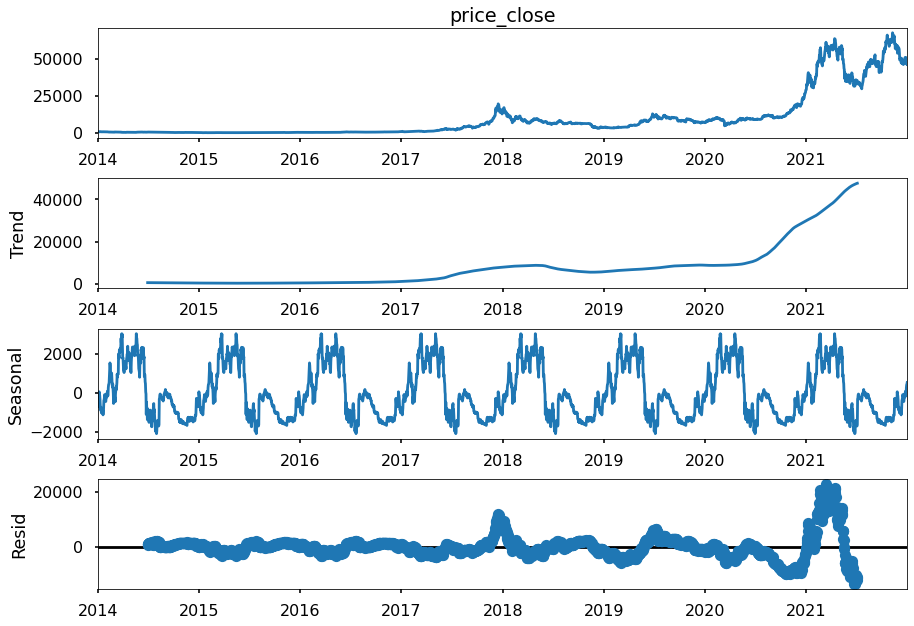

In [20]:
# Decomposition
decomposed = sm.tsa.seasonal_decompose(df['price_close'],freq=360) # The frequncy is annual
figure = decomposed.plot()
plt.show()

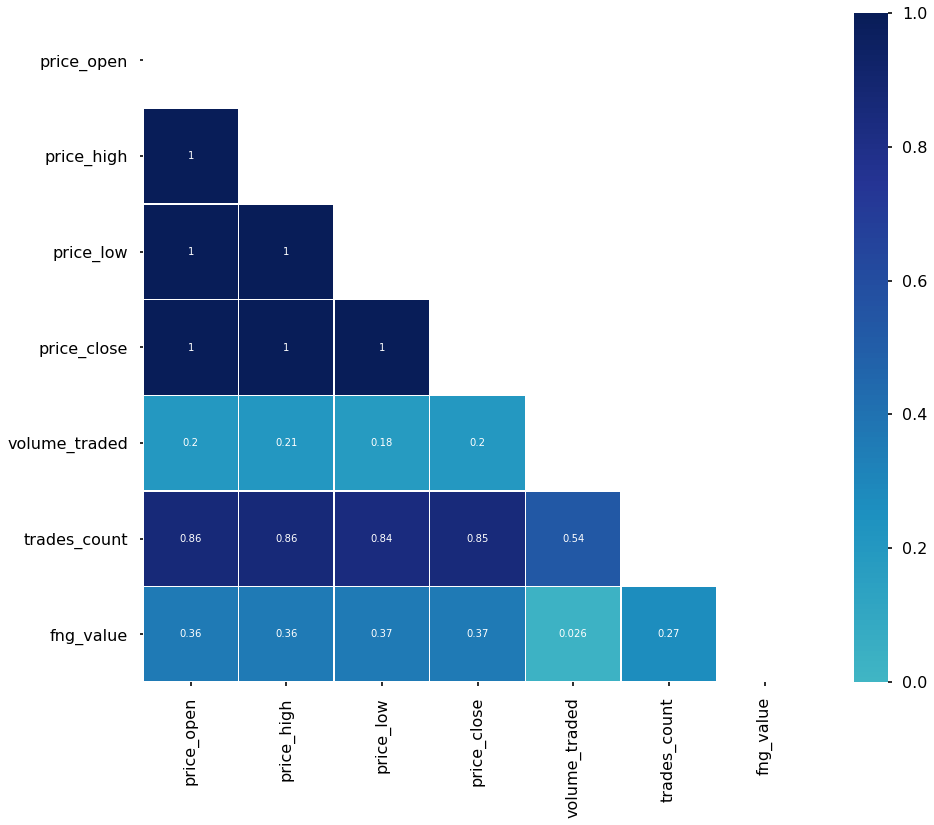

In [21]:
#Check correlation for numerical data
mask = np.zeros_like(df[df.columns].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15,15))
sns.heatmap(df[df.columns].corr(), linewidths=0.5, vmin=0, vmax=1, cbar_kws={'shrink': .82}, 
            annot=True, cmap='YlGnBu', center=0, mask=mask, square=True);

In [22]:
# Remove NA data
df_test=df
df_test=df_test.dropna()
df_test.head()

price_open  price_high  price_low  price_close  volume_traded  \
Timestamp                                                                   
2018-02-01    10148.99    10187.56    8400.00      9000.73   93531.112460   
2018-02-02     9014.22     9155.00    7540.99      8787.52   76536.207626   
2018-02-03     8805.76     9499.00    8022.90      9221.14   55394.847037   
2018-02-04     9178.00     9353.45    7751.20      8167.91   59264.863373   
2018-02-05     8190.78     8349.30    6425.75      6905.19  148125.482742   

            trades_count  fng_value fng_classification  
Timestamp                                               
2018-02-01        355931       30.0               Fear  
2018-02-02        279797       15.0       Extreme Fear  
2018-02-03        270732       40.0               Fear  
2018-02-04        233134       24.0       Extreme Fear  
2018-02-05        395717       11.0       Extreme Fear

In [23]:
# Remove unused column
df_test2=df_test.drop(['price_open', 'price_high', 'price_low', 'fng_classification'], axis=1)
df_test2.head()

price_close  volume_traded  trades_count  fng_value
Timestamp                                                      
2018-02-01      9000.73   93531.112460        355931       30.0
2018-02-02      8787.52   76536.207626        279797       15.0
2018-02-03      9221.14   55394.847037        270732       40.0
2018-02-04      8167.91   59264.863373        233134       24.0
2018-02-05      6905.19  148125.482742        395717       11.0

In [24]:
# Preview bitcoin price after cleaning
btc_trace = go.Scatter(x=df_test2.index, y=df_test2['price_close'], name= 'Price')
iplot([btc_trace])

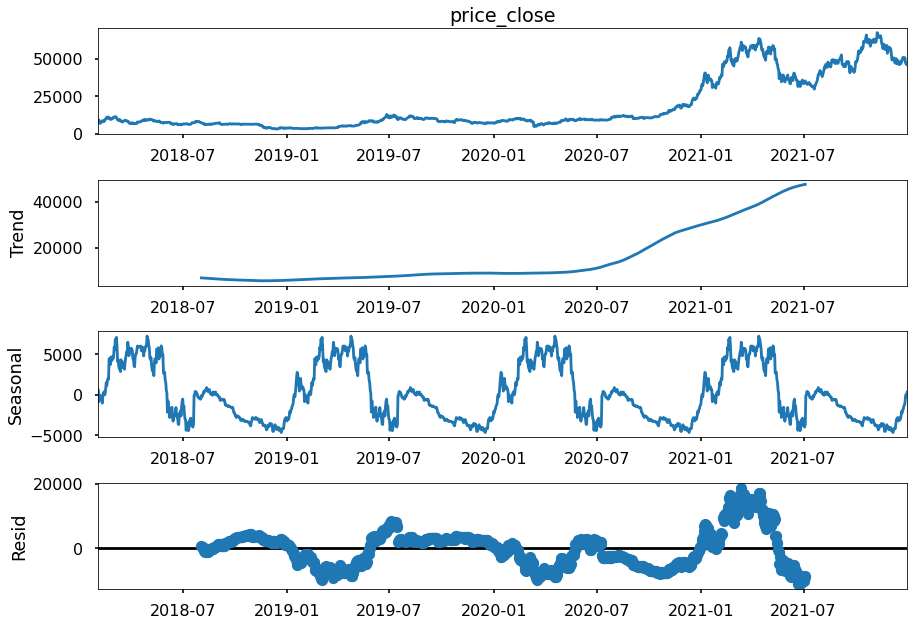

In [25]:
# Time series decomposition
decomposed2 = sm.tsa.seasonal_decompose(df_test2['price_close'],freq=360) # The frequncy is annual
figure = decomposed2.plot()
plt.show()

## Time Series Forecasting

Time Series data is an experimental data which has been observed at different points in time (usually evenly spaced, like once a day or once an hour or once a minute). For example, the data of airline ticket sales per day is a time series. However, just because a series of events has a time element does not automatically make it a time series, such as the dates of major airline disasters, which are randomly spaced and are not time series. These types of random processes are known as point process.

Time Series have several key features such as trend, seasonality, and noise. Forecasting is the process of making predictions of the future, based on past and present data. 

Here in this kernel, we attempt to perform Time Series Analysis on the Historic Bitcoin Price data. We can easily see from the **Data Exploration** section, that the Bitcoin prices were quite volatile and inconsistent over the years.  Its very hard to perform Time series analysis on such volatile data. But here we try to explore the different Time series forecasting models. All the models used in this Kernel are models that can probably handle the non-stationarity data like bitcoin price.

* Time Series forecasting with **Facebook Prophet**
* Time Series forecasting with **LSTM**

### 1. Time Series Forecasting with Prophet

Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

#### Univariate Time Series Forecasting

In [26]:
# Prepare data for prophet model
data_prophet = df_test2
data_prophet=data_prophet.reset_index()
data_prophet.head()

Timestamp  price_close  volume_traded  trades_count  fng_value
0 2018-02-01      9000.73   93531.112460        355931       30.0
1 2018-02-02      8787.52   76536.207626        279797       15.0
2 2018-02-03      9221.14   55394.847037        270732       40.0
3 2018-02-04      8167.91   59264.863373        233134       24.0
4 2018-02-05      6905.19  148125.482742        395717       11.0

In [27]:
# Create train and test sets
train_size = int(0.7 * len(data_prophet))
test_size = len(data_prophet) - train_size

univariate_df = data_prophet[['Timestamp', 'price_close']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

998 429


In [28]:
# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 32540.683098820027


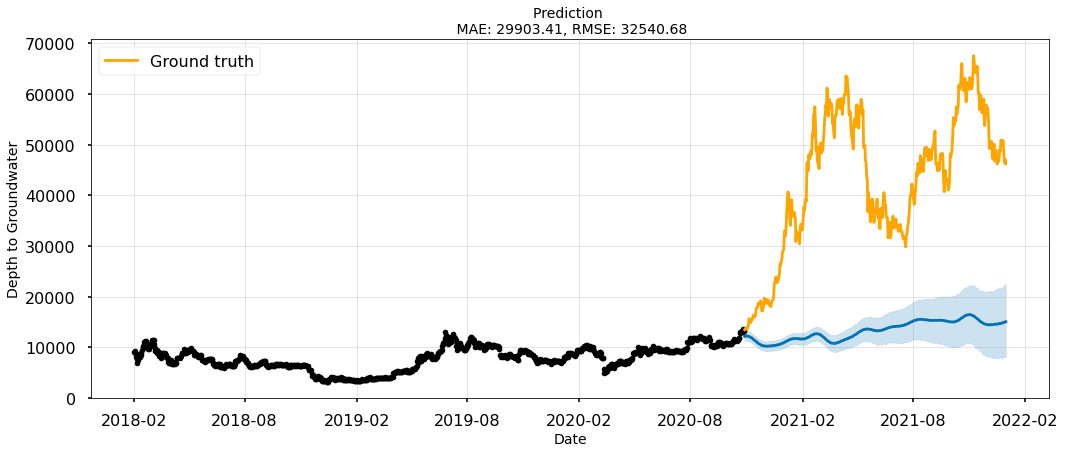

In [29]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

#### Multivariate Time Series Forecasting

In [30]:
# Set features for multivariate
feature_columns = ['volume_traded','trades_count','fng_value']
target_column = ['price_close']

train_size = int(0.7 * len(data_prophet))

multivariate_df = data_prophet[['Timestamp'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

ds        y  volume_traded  trades_count  fng_value
0 2018-02-01  9000.73   93531.112460        355931       30.0
1 2018-02-02  8787.52   76536.207626        279797       15.0
2 2018-02-03  9221.14   55394.847037        270732       40.0
3 2018-02-04  8167.91   59264.863373        233134       24.0
4 2018-02-05  6905.19  148125.482742        395717       11.0

In [31]:
# Train the model
model = Prophet()
model.add_regressor('volume_traded')
model.add_regressor('trades_count')
model.add_regressor('fng_value')

# Fit the model with train set
model.fit(train)

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print('RMSE: {}'.format(score_rmse))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE: 32371.99795683218


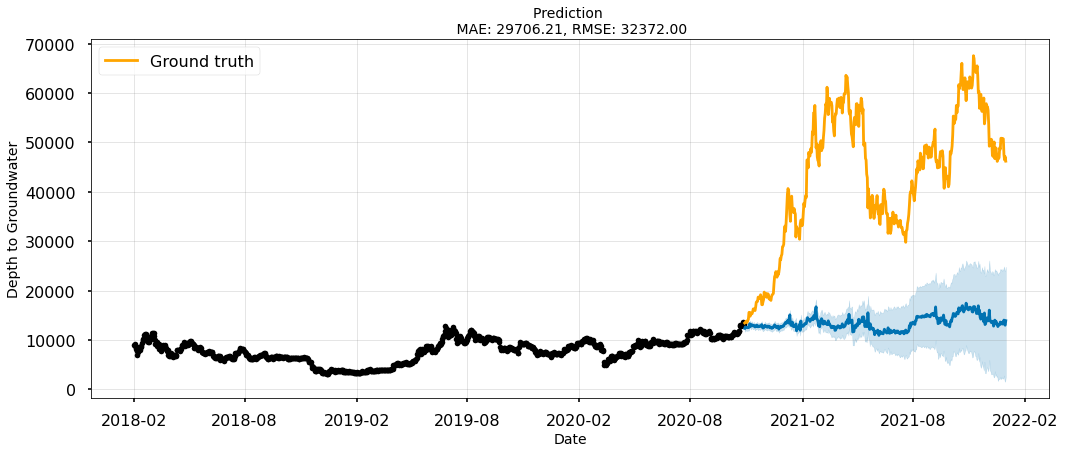

In [32]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

### 2. Time Series Forecasting with  LSTM

LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

#### Univariate Time Series Forecasting

In [33]:
# Normalize feature
data_LSTM = df_test2
values = data_LSTM['price_close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [34]:
# Split into train and test sets
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

998 429


In [35]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [36]:
# Create dataset with look back
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

997
428


In [37]:
# Reshape X for model training
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [38]:
# Train model
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

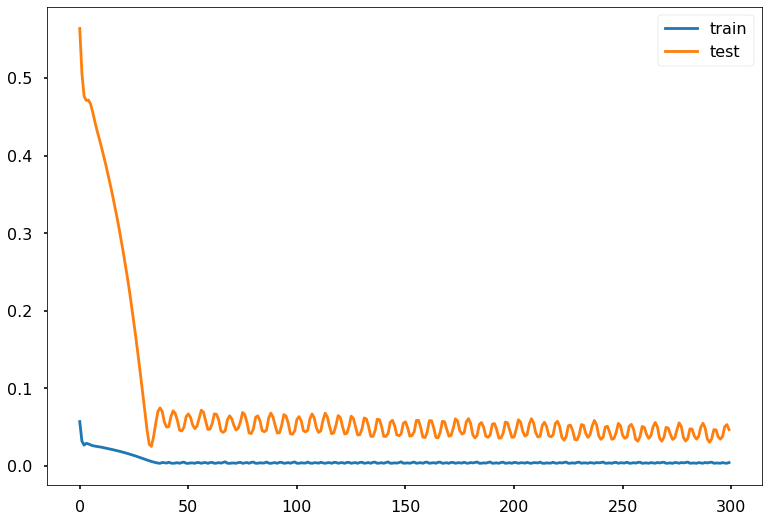

In [39]:
# Plot training and testing loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

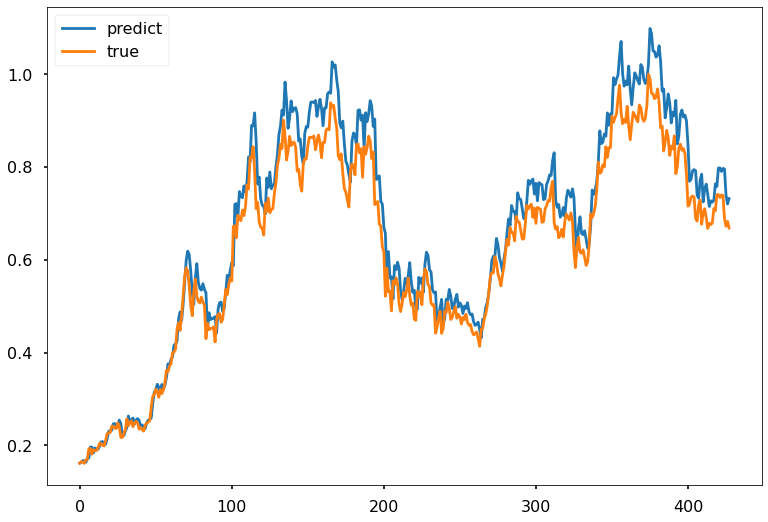

In [40]:
# Make prediction and compare with real close-price (scaled)
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [41]:
# Apply invert scaling
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [42]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('RMSE: %.3f' % rmse)

RMSE: 3786.343


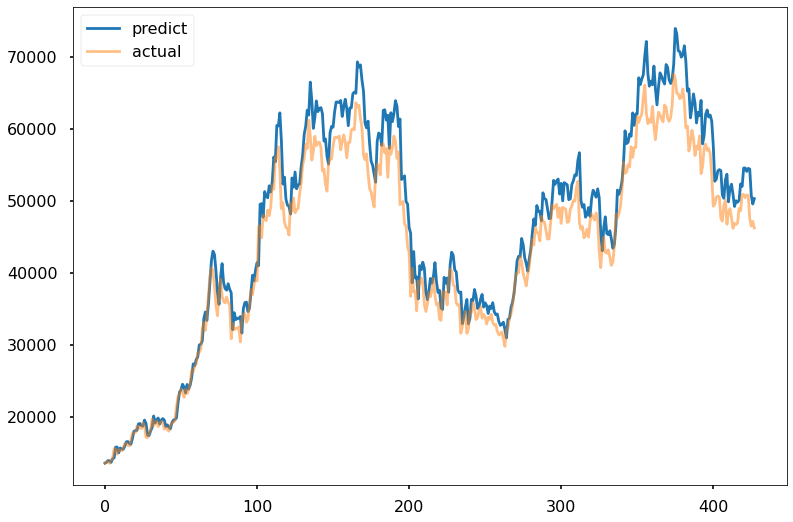

In [43]:
# Compare with real close-price (unscaled)
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [44]:
predictDates = data_LSTM.tail(len(testX)).index

In [45]:
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [46]:
# Compare with real close-price/with date (scaled)
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
iplot([predict_chart, actual_chart])

#### Multivariate Time Series Forecasting

In [47]:
# Function to convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [48]:
# Set features for multivariate
values = data_LSTM[['price_close'] + ['volume_traded'] + ['trades_count']+['fng_value']].values
values = values.astype('float32')
values.shape

(1427, 4)

In [49]:
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [50]:
# Frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.090377   0.351292   0.155505   0.277778  0.087065  0.284412  0.118348   
2   0.087065   0.284412   0.118348   0.111111  0.093801  0.201214  0.113924   
3   0.093801   0.201214   0.113924   0.388889  0.077439  0.216444  0.095575   
4   0.077439   0.216444   0.095575   0.211111  0.057823  0.566139  0.174922   
5   0.057823   0.566139   0.174922   0.066667  0.070015  0.853291  0.241229   

    var4(t)  
1  0.111111  
2  0.388889  
3  0.211111  
4  0.066667  
5  0.033333

In [51]:
# Drop unncessary columns
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
reframed.head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.090377   0.351292   0.155505   0.277778  0.087065
2   0.087065   0.284412   0.118348   0.111111  0.093801
3   0.093801   0.201214   0.113924   0.388889  0.077439
4   0.077439   0.216444   0.095575   0.211111  0.057823
5   0.057823   0.566139   0.174922   0.066667  0.070015

In [52]:
# Split into train and test sets
values = reframed.values
n_train_days = int(len(values) * 0.7)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(998, 1, 4) (998,) (428, 1, 4) (428,)


In [53]:
multi_model = Sequential()
multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
multi_model.add(Dense(1))
multi_model.compile(loss='mae', optimizer='adam')
multi_history = multi_model.fit(train_X, train_y, epochs=300, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

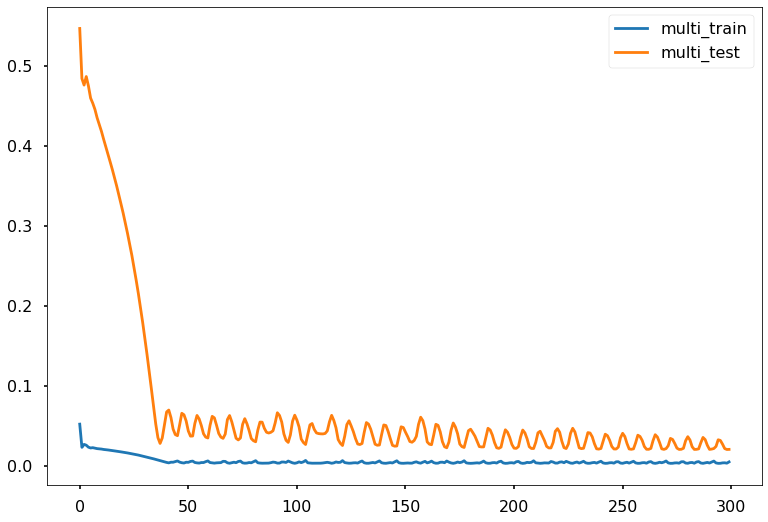

In [54]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

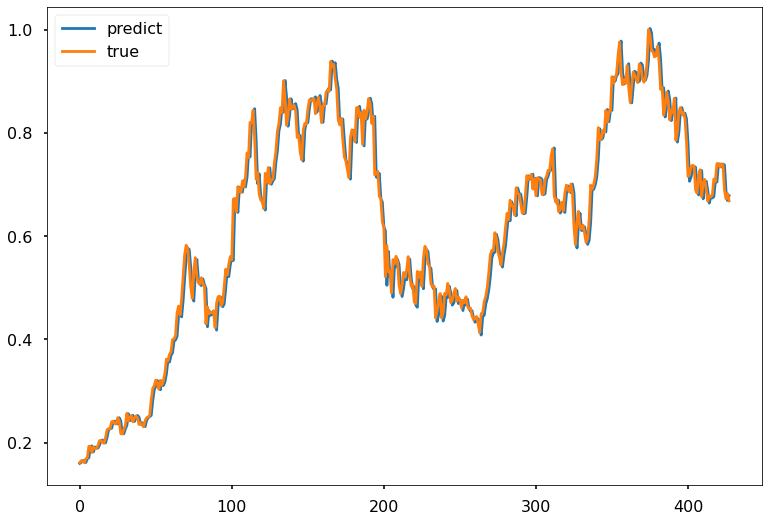

In [55]:
yhat = multi_model.predict(test_X)
pyplot.plot(yhat, label='predict')
pyplot.plot(test_y, label='true')
pyplot.legend()
pyplot.show()

In [56]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [57]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('RMSE: %.3f' % rmse)

RMSE: 1830.081


In [58]:
actual_chart = go.Scatter(x=predictDates, y=inv_y, name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat, name= 'Multi Predict Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
iplot([predict_chart, multi_predict_chart, actual_chart])